<a href="https://colab.research.google.com/github/MrVersatile007/AAAI2025/blob/main/AAAI25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing required libraries

In [ ]:
! pip install shap scikit-network

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import shap
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import sklearn
from sknetwork.embedding import SVD, Spectral
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns


# Synthetic Graph Generators

In [3]:
class GraphGenerators:

  def __init__(self):
    self.BA = []
    self.BA_I = []
    self.ER = []
    self.NW = []


  def barabasiAlbert(self,n: int, m1:int, m2:int, set1:int, set2:int):
    for i in range(set1):
      self.BA.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m1, seed= i)))
    for i in range(set1, (set1+set2)):
      self.BA.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m2, seed= i)))

    return self.BA

  def barabasiAlbert_internet(self, n: int, m1:int, m2:int, set1:int, set2:int):
    base_1 = nx.random_internet_as_graph(n, seed = 1)
    base_2 = nx.random_internet_as_graph(n, seed = 100)

    for i in range(set1):
      self.BA_I.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m1, seed= i, initial_graph=base_1)))
    for i in range(set1, (set1+set2)):
      self.BA_I.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m2, seed= i, initial_graph=base_2)))

    return self.BA_I

  def erdosRenyi(self, n: int, p1:float, p2:float, set1:int, set2:int):
    for i in range(set1):
      self.ER.append(nx.to_numpy_array(nx.erdos_renyi_graph(n, p = p1, seed= i)))
    for i in range(set1, set1+set2):
      self.ER.append(nx.to_numpy_array(nx.erdos_renyi_graph(n, p = p2, seed= i)))

    return self.ER

  def newmanWatts(self, n:int,  p1:float, p2:float, k1:int, k2:int, set1:int, set2:int):
    for i in range(set1):
      self.NW.append(nx.to_numpy_array(nx.newman_watts_strogatz_graph(n, k1, p1, seed=i)))
    for i in range(set1, set1+set2):
      self.NW.append(nx.to_numpy_array(nx.newman_watts_strogatz_graph(n, k2, p2, seed=i)))

    return self.NW



In [4]:
my_graphs = GraphGenerators()
graphs_type_1 = my_graphs.erdosRenyi(n= 50, p1= 0.4, p2= 0.7, set1=100, set2=100)
# graphs_type_2 = my_graphs.barabasiAlbert(n= 50,m1 = 4, m2 = 7, set1= 100, set2 = 100)
# graphs_type_3 = my_graphs.newmanWatts(n= 50, p1= 0.5, p2= 0.7, k1=3, k2=5, set1=100, set2=100)
# graphs_type_4 = my_graphs.barabasiAlbert_internet(n= 1000, m1= 3, m2= 5, set1=100, set2=100)


# Change-point Detection Algorithm including Graph Feature Extraction

In [5]:
class ChangePointDetection:
  def __init__(self, graphs):
    self.graphs = graphs

###     FEATURE EXTRACTORS

  def deg_centrality(self, graphs):
    self.DC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.degree_centrality(G).values()]
      self.DC.append(float_list)
    return self.DC

  def betweenness_centrality(self, graphs):
    self.BC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.betweenness_centrality(G).values()]
      self.BC.append(float_list)

    return self.BC

  def eigenvector_centrality(self, graphs):
    self.EV = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.eigenvector_centrality_numpy(G).values()]
      self.EV.append(float_list)

    return self.EV

  def closeness_centrality(self, graphs):
    self.CC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.closeness_centrality(G).values()]
      self.CC.append(float_list)

    return self.CC

  def LSVDembedding(self, graphs):
    self.LSVD = []
    for matrix in graphs:
      degree_matrix = np.diag(np.sum(matrix, axis=1))
      laplacian_matrix = degree_matrix - matrix

      U, S, V = np.linalg.svd(laplacian_matrix)

      self.LSVD.append(S)

    return self.LSVD

  def SVDEmbedding(self, graphs):
    self.SVD = []

    for matrix in graphs:
      # G = nx.from_numpy_array(matrix, create_using = nx.Graph)
      two_dim_mats = SVD(n_components = 2).fit_transform(matrix)
      self.SVD.append(two_dim_mats.flatten())

    return self.SVD

###     MARTINGALE TEST FRAMEWORK

  def strangenessPoint(self, data):
    kmeans = KMeans(n_clusters=1, random_state=7)
    strangeness_values = kmeans.fit_transform(data)
    # strangeness = [value.tolist() for value in strangeness_values]
    return strangeness_values

  def getPValue(self, strangeness):
    rand_term = random.uniform(0, 1)
    term1 = []
    term2 = []
    for i in range(len(strangeness)):
        if strangeness[i] > strangeness[-1]:
            term1.append(i)
        elif strangeness[i] == strangeness[-1]:
            term2.append(i)

    pvalue = (len(term1) + (rand_term * len(term2))) / (i + 1)

    return pvalue

  def martingaleTest(self, data, threshold , epsilon = 0.8,  detect=True):
    self.pvalues = []
    self.change_detected_instant = []
    martingale = [1] #Mn+1
    self.saved_martingales = [1] #Mn
    self.T = [] #window
    self.saved_strangeness = []
    for i in range(len(data)):
      if len(self.T) == 0:
        strangeness = [0]
      else:
        #Strangeness one vector has one value
        strangeness = self.strangenessPoint(self.T+ [data[i]])
      self.saved_strangeness.append(strangeness[-1])

      self.pvalues.append(self.getPValue(strangeness))

      martingale.append(martingale[-1] * epsilon * (self.pvalues[-1] ** (epsilon - 1)))

      self.saved_martingales.append(martingale[-1])

      if detect == False:
        self.T.append(data[i])
      else:
        if martingale[-1] > threshold:
          print('CHANGE DETECTED')
          self.T = []
          self.change_detected_instant.append(i)
          martingale[-1] = 1
          # self.T.append(data[i])

        else:
          self.T.append(data[i])
          # if len(self.T) > window:
          #   self.T.pop(0)
    print(f'Changes detected at instants: {self.change_detected_instant}')
    print(f'Pvalues : {self.pvalues}')
    print(f'Saved strangeness {self.saved_strangeness}')
    print(f'saved martingales {self.saved_martingales}')
    return {'change_detected_instant' : self.change_detected_instant,
            'pvalues': self.pvalues,
            'strangeness': self.saved_strangeness,
            'martingales': np.array(self.saved_martingales[1:])}

  def process_instant(self, data_at_instant, T, martingale, epsilon):
    """Process all features at a given instant."""
    martingale_sum = 0
    num_features = len(data_at_instant)

    new_martingales = []
    p_values = []
    strangeness_values = []

    for j in range(num_features):
        feature_data = data_at_instant[j]
        prev_martingale = martingale[j][-1]
        prev_window = T[j]

        if len(prev_window) == 0:
            strangeness = [0]
        else:
            temp = prev_window + [feature_data]
            strangeness = self.strangenessPoint(temp)

        p_value = self.getPValue(strangeness)
        new_martingale_value = prev_martingale * epsilon * (p_value ** (epsilon - 1))

        # Update window
        prev_window.append(feature_data)

        # Collect results
        new_martingales.append(new_martingale_value)
        p_values.append(p_value)
        strangeness_values.append(strangeness[-1])
        martingale_sum += new_martingale_value

    # avg_martingale_sum = martingale_sum / num_features
    # return new_martingales, p_values, strangeness_values, avg_martingale_sum, T
    return new_martingales, p_values, strangeness_values, martingale_sum, T



  def multiviewMartingaleTest(self, data, threshold=20, epsilon=0.8):
    num_features = len(data)
    num_instants = len(data[0])

    # Initialize variables
    self.pvalues = [[] for _ in range(num_features)]
    self.change_detected_instant = []
    self.martingale = [[1] for _ in range(num_features)]  # Mn+1
    self.saved_martingales = [[1] for _ in range(num_features)]  # Mn
    self.saved_martingale_sum = [4]  # Initial value, adjust if necessary
    T = [[] for _ in range(num_features)]  # Windowed data
    self.saved_strangeness = [[] for _ in range(num_features)]

    for i in range(num_instants):
        # Process the current instant for all features
        new_martingales, p_values, strangeness_values, avg_martingale_sum, T = self.process_instant(
            [data[j][i] for j in range(num_features)], T, self.martingale, epsilon
        )

        # Update the stored values
        for j in range(num_features):
            self.martingale[j].append(new_martingales[j])
            self.saved_martingales[j].append(new_martingales[j])
            self.pvalues[j].append(p_values[j])
            self.saved_strangeness[j].append(strangeness_values[j])

        # Check for change point detection
        self.saved_martingale_sum.append(avg_martingale_sum)
        if avg_martingale_sum > threshold:
            print(f'CHANGE DETECTED at instant {i}')
            self.change_detected_instant.append(i)

            # Reset martingales and windows after change detection
            T = [[] for _ in range(num_features)]
            for j in range(num_features):
                self.martingale[j][-1] = 1
                T[j].append(data[j][i])  # Start new window with current data

    print(f'Changes detected at instants: {self.change_detected_instant}')
    print(f'Pvalues: {self.pvalues}')
    print(f'Saved strangeness: {self.saved_strangeness}')
    print(f'Saved martingales: {self.saved_martingales}')
    return {
        'change_detected_instant': self.change_detected_instant,
        'pvalues': self.pvalues,
        'strangeness': self.saved_strangeness,
        'martingale_sum': np.array(self.saved_martingale_sum[1:])
    }


In [20]:
Obj = ChangePointDetection(graphs_type_1)
dc = Obj.deg_centrality(graphs_type_1)
bc = Obj.betweenness_centrality(graphs_type_1)
ev = Obj.eigenvector_centrality(graphs_type_1)
cc = Obj.closeness_centrality(graphs_type_1)
svd = Obj.SVDEmbedding(graphs_type_1)
lsvd = Obj.LSVDembedding(graphs_type_1)
print(f'Degree Centrality Shapes:       {len(dc), len(dc[1])}')
print(f'Betweenness Centrality Shapes:  {len(bc), len(bc[1])}')
print(f'Eigen Vec Centrality Shapes:    {len(ev), len(ev[1])}')
print(f'Closeness Centrality Shapes:    {len(cc), len(ev[1])}')
print(f'SVD Shapes:                     {len(svd), len(svd[1])}')
print(f'LSVD Shapes:                    {len(lsvd), len(lsvd[1])}')

Degree Centrality Shapes:       (200, 50)
Betweenness Centrality Shapes:  (200, 50)
Eigen Vec Centrality Shapes:    (200, 50)
Closeness Centrality Shapes:    (200, 50)
SVD Shapes:                     (200, 100)
LSVD Shapes:                    (200, 50)


# Performing Martingale Test with Change Point Detection

In [ ]:
Mdc = Obj.martingaleTest(dc, threshold= 15, detect=True)
Mbc = Obj.martingaleTest(bc,threshold= 15, detect=True)
Mev = Obj.martingaleTest(ev, threshold= 15, detect=True)
Mcc = Obj.martingaleTest(cc, threshold= 15, detect=True)
Msvd = Obj.martingaleTest(svd, threshold= 15, detect=True)
Mlsvd = Obj.martingaleTest(lsvd, threshold= 15, detect=True)
Msum = Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales']
Mavg = (Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales'])/6


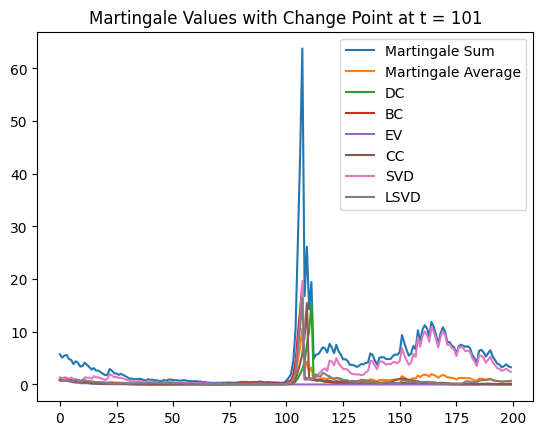

In [22]:
#Observing the martingale values with change point at 101 time instant

plt.plot(Msum)
plt.plot(Mavg)
plt.plot(Mdc['martingales'])
plt.plot(Mbc['martingales'])
plt.plot(Mev['martingales'])
plt.plot(Mcc['martingales'])
plt.plot(Msvd['martingales'])
plt.plot(Mlsvd['martingales'])
plt.legend(['Martingale Sum', 'Martingale Average', 'DC', 'BC', 'EV', 'CC', 'SVD', 'LSVD'])
plt.title('Martingale Values with Change Point at t = 101')
plt.show()

In [23]:
Msvd['change_detected_instant']

[107]

# Demonstration to observe behaviour of SHAP values

In [ ]:
Mdc = Obj.martingaleTest(dc, 15, detect=False)
Mbc = Obj.martingaleTest(bc, 15, detect=False)
Mev = Obj.martingaleTest(ev, 15, detect=False)
Mcc = Obj.martingaleTest(cc, 15, detect=False)
Msvd = Obj.martingaleTest(svd, 15, detect=False)
Mlsvd = Obj.martingaleTest(lsvd, 15, detect=False)
Msum = Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales']
Mavg = (Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales'])/6


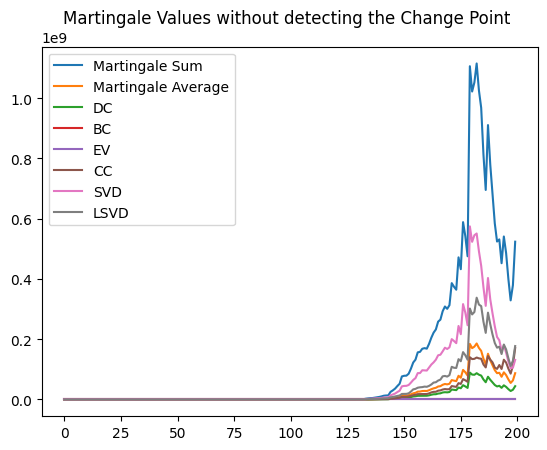

In [25]:
#They are supposed to increase exponentially

plt.plot(Msum)
plt.plot(Mavg)
plt.plot(Mdc['martingales'])
plt.plot(Mbc['martingales'])
plt.plot(Mev['martingales'])
plt.plot(Mcc['martingales'])
plt.plot(Msvd['martingales'])
plt.plot(Mlsvd['martingales'])
plt.legend(['Martingale Sum', 'Martingale Average', 'DC', 'BC', 'EV', 'CC', 'SVD', 'LSVD'])
plt.title('Martingale Values without detecting the Change Point ')
plt.show()

In [26]:
X = np.vstack((Mdc['martingales'], Mbc['martingales'], Mev['martingales'], Mcc['martingales'], Msvd['martingales'], Mlsvd['martingales']))
y = y = [20 if i>=101 else 1 for i in range(200) ]
X = X.transpose()
X.shape, len(y)

((200, 6), 200)

In [27]:
# Our Custom Threshold model
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the custom model
class CustomThresholdModel(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        """
        Initialize the model with a threshold.
        :param threshold: The threshold value for the sum of the input features.
        """
        self.threshold = threshold

    def fit(self, X, y=None):
        """
        Fit the model. This method doesn't do anything as our model doesn't require training.
        :param X: Input features.
        :param y: True labels (optional).
        :return: self
        """
        return self

    def predict(self, X):
        """
        Predict the labels based on the input features.
        :param X: Input features.
        :return: Predicted labels (1 or 0).
        """
        # Calculate the sum of input features
        sums = np.sum(X, axis=1)
        # Apply the threshold
        return (sums > self.threshold).astype(int)

# Step 2: Get the data ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create and use the model
explanation_model = CustomThresholdModel(threshold=20)
explanation_model.fit(X_train, y_train)  # Fit the model (though fitting is not necessary in this case)
predictions = explanation_model.predict(X_test)


In [ ]:
explainer = shap.KernelExplainer(explanation_model.predict, X)
shap_values = explainer.shap_values(X)

In [29]:
import matplotlib.pyplot as plt

def plot_results(martingale_sum, Mdc, Mbc, Mev, Mcc, Msvd, Mlsvd, shap_values, a, b):
  plt.figure(figsize=(10, 10))

  plt.subplot(2,1,1)
  x_range = range(a,b)
  plt.plot(x_range, Msum[a:b], color='cyan')
  plt.plot(x_range, Mavg[a:b], color='teal')
  plt.plot(x_range, Mdc['martingales'][a:b], color='orange')
  plt.plot(x_range, Mbc['martingales'][a:b], color='green')
  plt.plot(x_range, Mev['martingales'][a:b], color='red')
  plt.plot(x_range, Mcc['martingales'][a:b], color='purple')
  plt.plot(x_range, Msvd['martingales'][a:b], color='brown')
  plt.plot(x_range, Mlsvd['martingales'][a:b], color='pink')

  plt.legend(['Martingale Sum', 'Martingale Average', 'Degree Centrality', 'Betweenness Centrality', 'Eigen Vector Centrality', 'Closeness Centrality', 'Singular Value Decomposition', 'Laplacian SVD'])
  plt.title('Martingale measures')

  plt.subplot(2,1,2)
  plt.plot(x_range, shap_values[:,0][a:b], color='orange')
  plt.plot(x_range, shap_values[:,1][a:b], color='green')
  plt.plot(x_range, shap_values[:,2][a:b], color='red')
  plt.plot(x_range, shap_values[:,3][a:b], color='purple')
  plt.plot(x_range, shap_values[:,4][a:b], color='brown')
  plt.plot(x_range, shap_values[:,5][a:b], color='pink')
  # plt.axvline(x=108, color='r', linestyle='--')
  plt.legend(['Degree Centrality', 'Betweenness Centrality', 'Eigen Vector Centrality', 'Closeness Centrality', 'Singular Value Decomposition', 'Laplacian SVD'])
  plt.title('SHAP values with Kernel explanation on martingale custom threshold model')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


In [ ]:
plot_results(Msum, Mdc, Mbc, Mev, Mcc, Msvd, Mlsvd, shap_values, 0, 200)

The above result:

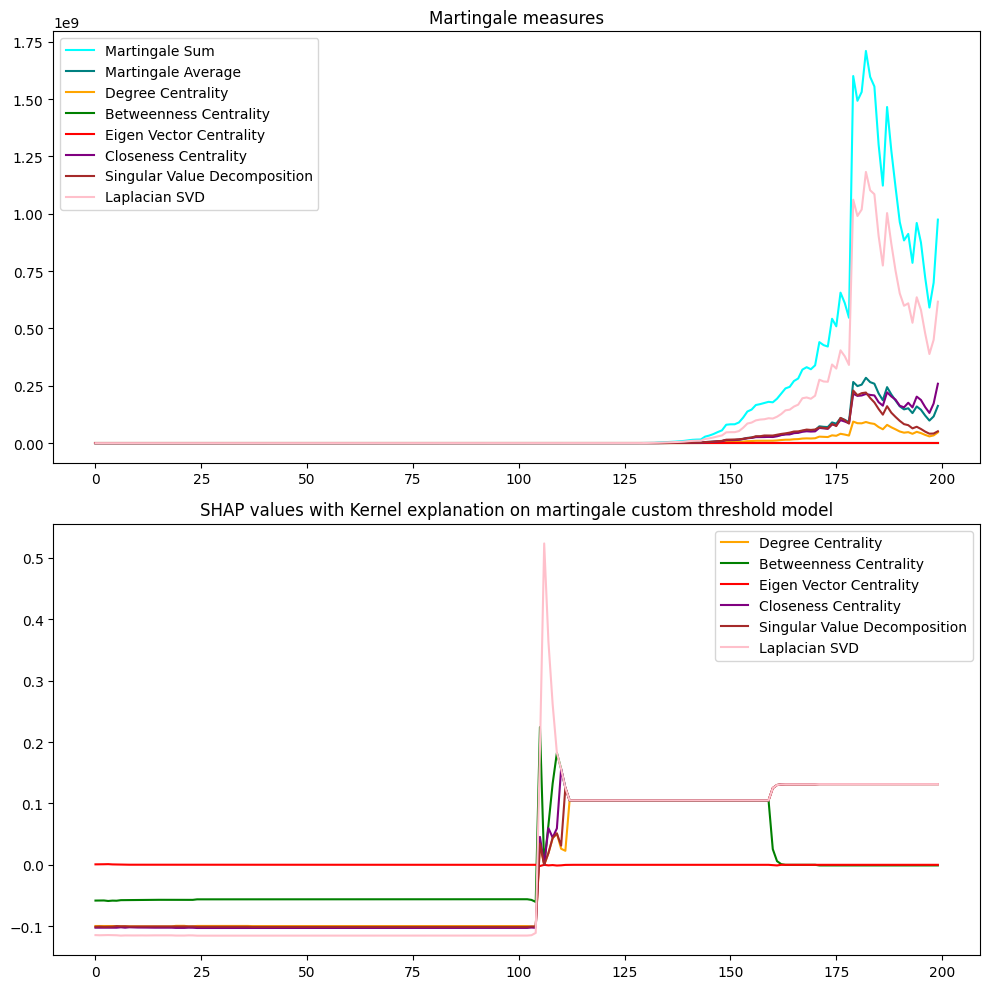

# Working with real world data

The MIT data is taken from :

http://realitycommons.media.mit.edu/index.html

In [31]:
from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/MyDrive/Thesis2/SocialEvolution/Proximity.csv')
raw_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user.id,remote.user.id.if.known,time,prob2
0,58,42,2007-09-05 14:02:11,0.034
1,58,49,2007-09-05 14:02:11,0.000
2,58,54,2007-09-05 14:02:11,NaN
3,58,57,2007-09-05 14:02:11,0.233
4,58,74,2007-09-05 14:02:11,NaN


# Preprocess the data and convert it into the graphs and dates

In [32]:
raw_data.dropna(inplace=True, subset=['prob2'])
raw_data = raw_data[raw_data.prob2 > 0.3]
raw_data['time'] = pd.to_datetime(raw_data['time'])
raw_data['date'] = raw_data.time.dt.date
raw_data.drop(['time', 'prob2'], axis = 1, inplace=True)
raw_data.drop_duplicates(inplace=True, keep='first')

raw_data.reset_index(drop=True, inplace=True)
filtered_data = raw_data

filtered_data.to_csv('filtered_data.csv')

filtered_dates = raw_data.drop_duplicates(subset=['date'], keep='first')
filtered_dates.reset_index(drop=True, inplace=True)
filtered_dates.index = filtered_dates.index + 1
filtered_dates = filtered_dates.date

filtered_dates.to_csv('filtered_dates.csv')

In [33]:
filtered_data

,user.id,remote.user.id.if.known,date
0,58,70,2007-09-05
1,5,30,2008-01-09
2,5,42,2008-01-09
3,5,47,2008-01-09
4,35,51,2008-01-21
...,...,...,...
24421,67,22,2009-06-24
24422,30,42,2009-06-24
24423,67,22,2009-06-25
24424,64,44,2009-07-05


In [34]:
filtered_dates

,date
1,2007-09-05
2,2008-01-09
3,2008-01-21
4,2008-01-23
5,2008-01-29
...,...
285,2009-06-23
286,2009-06-24
287,2009-06-25
288,2009-07-05


#Creating graphs out of data

In [ ]:
# filtered_data['user.id'].max(), filtered_data['remote.user.id.if.known'].min()
result_graphs = []
current_date = None
current_group = []

for _, row in filtered_data.iterrows():
    date = row['date']
    edge = (row['user.id'], row['remote.user.id.if.known'])

    if date != current_date:
        # Start a new group
        if current_group:
          result_graphs.append(current_group)
        current_group = [edge]
        current_date = date
    else:
        current_group.append(edge)

# Append the last group
if current_group:
    result_graphs.append(current_group)

# Display the list of lists of tuples
print(result_graphs)


graphs = []
for group in result_graphs:
    G = nx.Graph()
    G.add_nodes_from(range(1,80))
    for edge in group:
        G.add_edge(*edge)
    graphs.append(G)



In [36]:
#Just making sure we didn't miss out any edges

list_lengths = [len(inner_list) for inner_list in result_graphs]

sum(list_lengths) == len(filtered_data),  #number of edges should be 24426 and number of graphs should be 289

(True,)

In [37]:
#our graph matrices

adj_matrices = []

for graph in graphs:
  adj_matrices.append(nx.to_numpy_array(graph, dtype=int))

len(adj_matrices)

289

# Do the same test as previous but with MIT data

In [14]:
Obj = ChangePointDetection(adj_matrices)
dc = Obj.deg_centrality(adj_matrices)
bc = Obj.betweenness_centrality(adj_matrices)
ev = Obj.eigenvector_centrality(adj_matrices)
cc = Obj.closeness_centrality(adj_matrices)
svd = Obj.SVDEmbedding(adj_matrices)
lsvd = Obj.LSVDembedding(adj_matrices)
print(f'Degree Centrality Shapes:       {len(dc), len(dc[1])}')
print(f'Betweenness Centrality Shapes:  {len(bc), len(bc[1])}')
print(f'Eigen Vec Centrality Shapes:    {len(ev), len(ev[1])}')
print(f'Closeness Centrality Shapes:    {len(cc), len(ev[1])}')
print(f'SVD Shapes:                     {len(svd), len(svd[1])}')
print(f'LSVD Shapes:                    {len(lsvd), len(lsvd[1])}')

Degree Centrality Shapes:       (289, 79)
Betweenness Centrality Shapes:  (289, 79)
Eigen Vec Centrality Shapes:    (289, 79)
Closeness Centrality Shapes:    (289, 79)
SVD Shapes:                     (289, 158)
LSVD Shapes:                    (289, 79)


# Events to observe:
 1. Christmas and New Year event on Dec 25th and Jan 1st

 Graph instants 81-141 (Dec 1st, 2008 - Jan 31st, 2009)

 2. Columbus Day on Oct 13th (Graph instant 33)

 Graph instants 1- 60 (Jan 9th - Nov 5th)

 3. Memorial Day and Summer Break on on May 26th

 Graph instants 230 - 289 (Apr 29th - Jul 11th)

In [15]:
NewYear = {
    'dc_NewYear': dc[81:141],
    'bc_NewYear': bc[81:141],
    'ev_NewYear': ev[81:141],
    'cc_NewYear': cc[81:141],
    'svd_NewYear': svd[81:141],
    'lsvd_NewYear': lsvd[81:141]
}

ColumbusDay = {
    'dc_ColumbusDay': dc[1:60],
    'bc_ColumbusDay': bc[1:60],
    'ev_ColumbusDay': ev[1:60],
    'cc_ColumbusDay': cc[1:60],
    'svd_ColumbusDay': svd[1:60],
    'lsvd_ColumbusDay': lsvd[1:60]
}


Individual martingale tests on a set of features and change points:

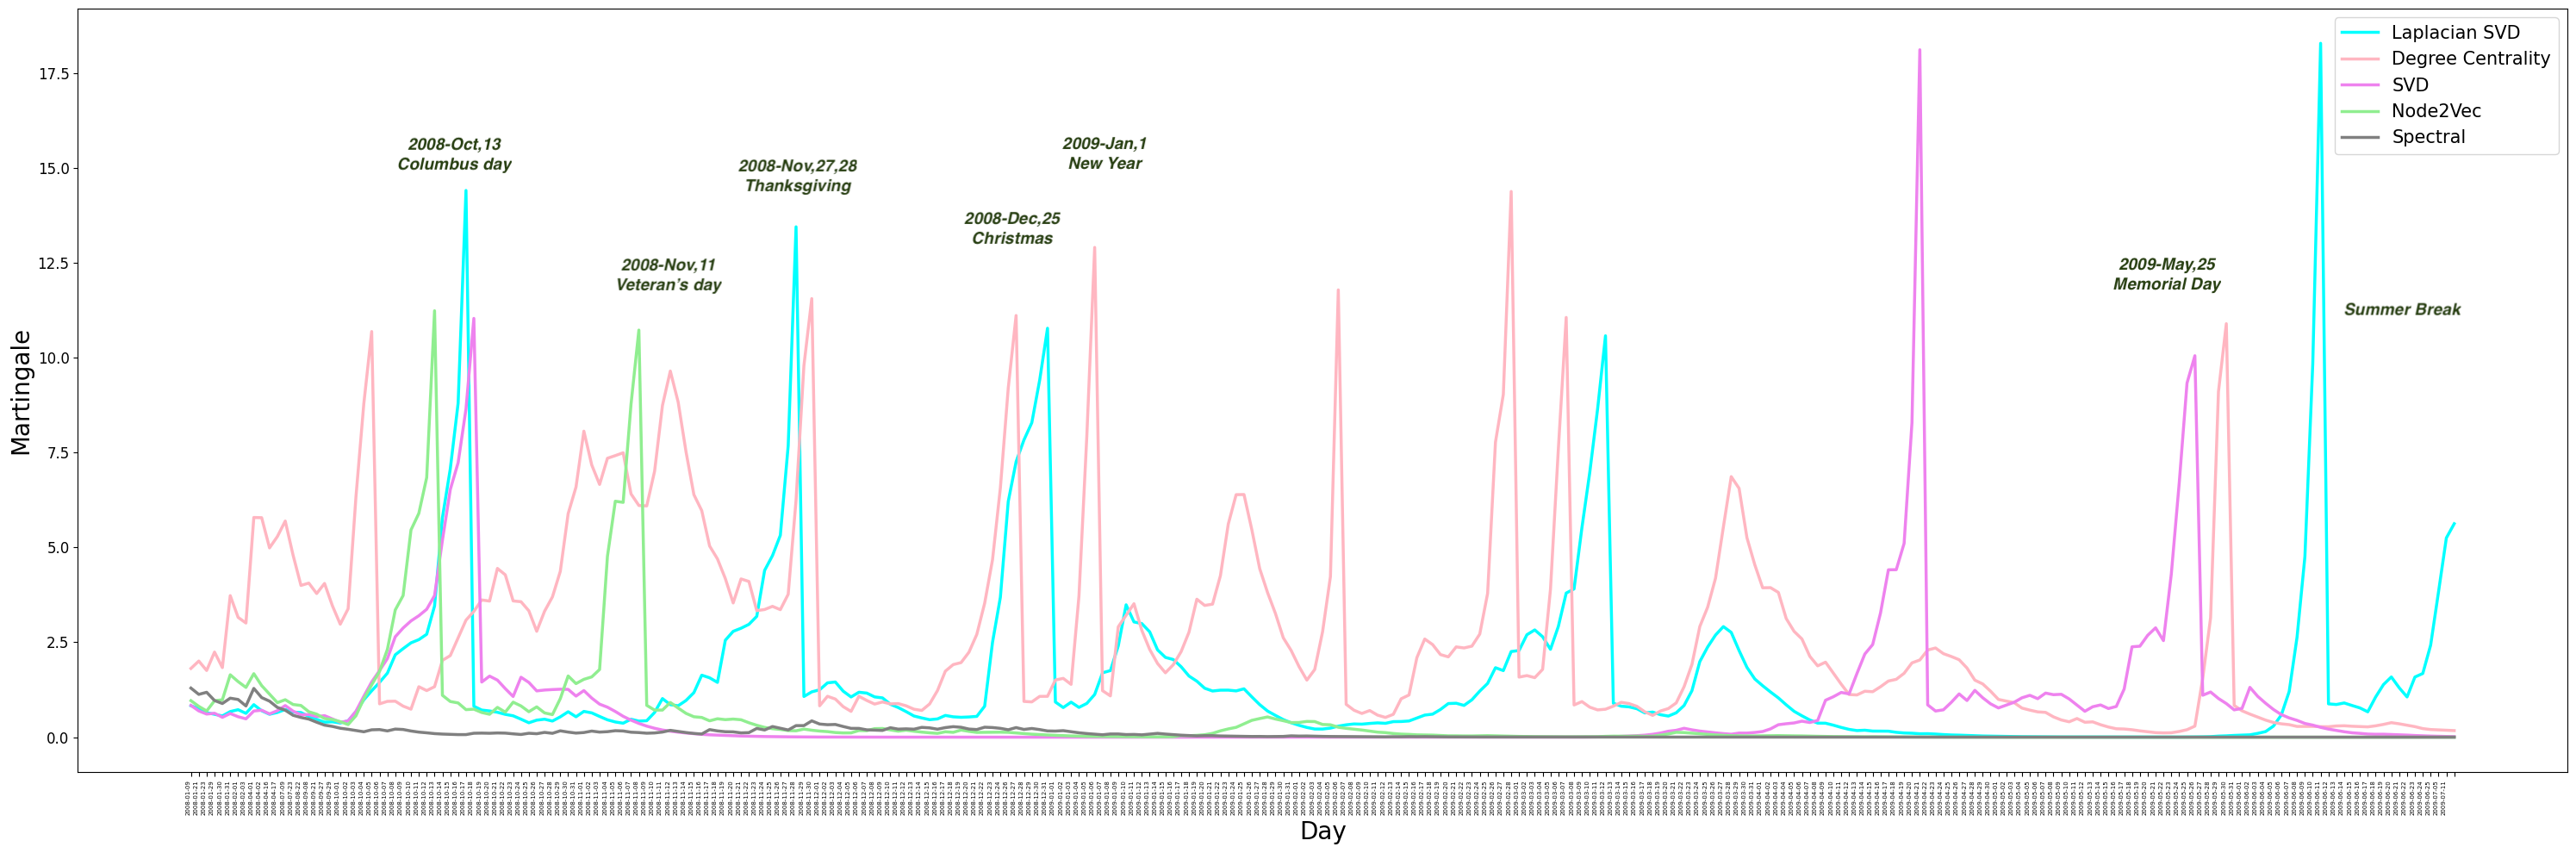

# Observing New Year event

In [ ]:
Mdc_ny = Obj.martingaleTest(NewYear['dc_NewYear'], 20, detect=False)
Mbc_ny = Obj.martingaleTest(NewYear['bc_NewYear'], 20, detect=False)
Mev_ny = Obj.martingaleTest(NewYear['ev_NewYear'], 20, detect=False)
Mcc_ny = Obj.martingaleTest(NewYear['cc_NewYear'], 20, detect=False)
Msvd_ny = Obj.martingaleTest(NewYear['svd_NewYear'], 20, detect=False)
Mlsvd_ny = Obj.martingaleTest(NewYear['lsvd_NewYear'], 20, detect=False)

In [17]:
Msum_ny = Mdc_ny['martingales']+Mbc_ny['martingales']+Mev_ny['martingales']+Mcc_ny['martingales']+Msvd_ny['martingales'] + Mlsvd_ny['martingales']
Mavg_ny = (Mdc_ny['martingales']+Mbc_ny['martingales']+Mev_ny['martingales']+Mcc_ny['martingales']+Msvd_ny['martingales'] + Mlsvd_ny['martingales'])/6

In [18]:
X_ny = np.vstack((Mdc_ny['martingales'], Mbc_ny['martingales'], Mev_ny['martingales'], Mcc_ny['martingales'], Msvd_ny['martingales'], Mlsvd_ny['martingales']))
X_ny = X_ny.transpose()
X_ny.shape

(60, 6)

In [38]:
explainer2 = shap.KernelExplainer(explanation_model.predict, X_ny)
shap_values2 = explainer2.shap_values(X_ny)

  0%|          | 0/60 [00:00<?, ?it/s]

<ipython-input-39-11d28b45ec85>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
<ipython-input-39-11d28b45ec85>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')


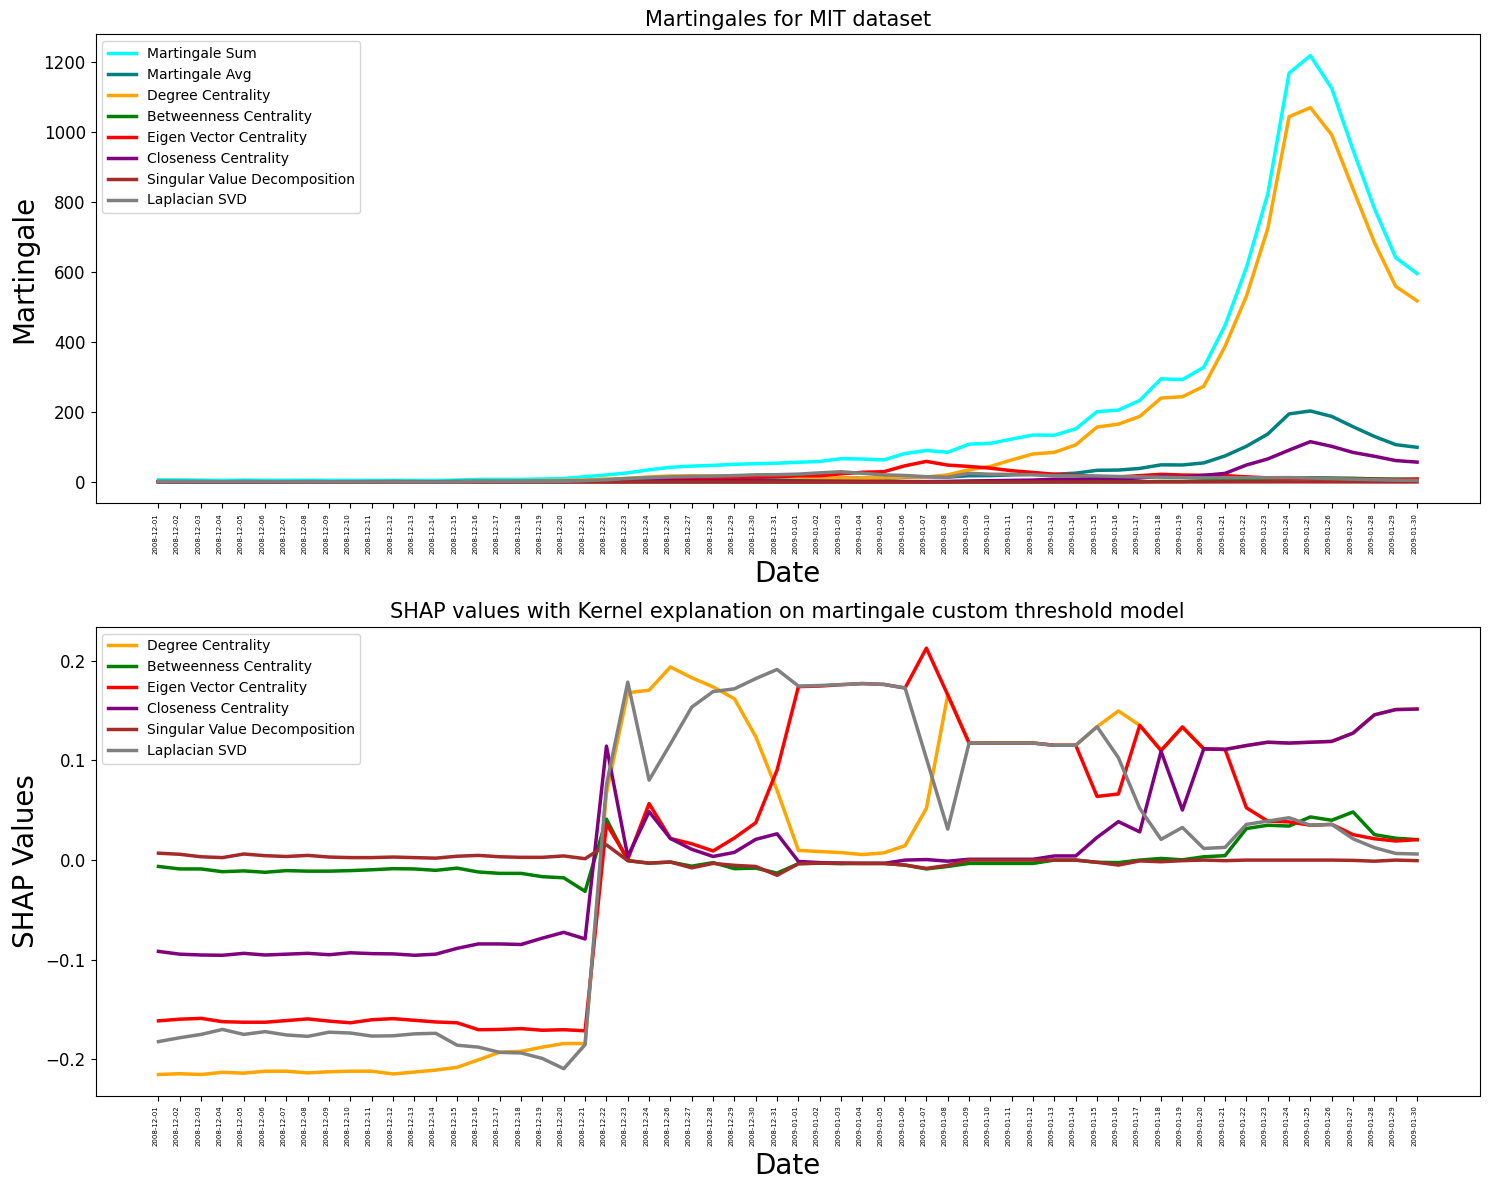

In [39]:
dates_NewYear = filtered_dates.astype(str)[81:141]
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('Martingale', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Martingales for MIT dataset', fontsize = 15)

ax = sns.lineplot(y = Msum_ny, x= dates_NewYear, color = 'cyan', label='Martingale Sum', linewidth = 2.5)
sns.lineplot(y = Mavg_ny, x = dates_NewYear, color = 'teal', label='Martingale Avg', linewidth = 2.5)
sns.lineplot(y = Mdc_ny['martingales'], x = dates_NewYear, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = Mbc_ny['martingales'], x = dates_NewYear, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = Mev_ny['martingales'], x = dates_NewYear, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = Mcc_ny['martingales'], x = dates_NewYear, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = Msvd_ny['martingales'], x = dates_NewYear, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = Mlsvd_ny['martingales'], x = dates_NewYear, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)


plt.subplot(2,1,2)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('SHAP Values', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('SHAP values with Kernel explanation on martingale custom threshold model', fontsize = 15)


ax = sns.lineplot(y = shap_values2[:,0], x = dates_NewYear, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,1], x = dates_NewYear, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,2], x = dates_NewYear, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,3], x = dates_NewYear, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,4], x = dates_NewYear, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,5], x = dates_NewYear, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

# Observing Columbus Day

In [ ]:
Mdc_cd = Obj.martingaleTest(ColumbusDay['dc_ColumbusDay'], 20, detect=False)
Mbc_cd = Obj.martingaleTest(ColumbusDay['bc_ColumbusDay'], 20, detect=False)
Mev_cd = Obj.martingaleTest(ColumbusDay['ev_ColumbusDay'], 20, detect=False)
Mcc_cd = Obj.martingaleTest(ColumbusDay['cc_ColumbusDay'], 20, detect=False)
Msvd_cd = Obj.martingaleTest(ColumbusDay['svd_ColumbusDay'], 20, detect=False)
Mlsvd_cd = Obj.martingaleTest(ColumbusDay['lsvd_ColumbusDay'], 20, detect=False)


In [41]:
Msum_cd = Mdc_cd['martingales'] + Mbc_cd['martingales'] + Mev_cd['martingales'] + Mcc_cd['martingales'] + Msvd_cd['martingales'] + Mlsvd_cd['martingales']
Mavg_cd = (Mdc_cd['martingales'] + Mbc_cd['martingales'] + Mev_cd['martingales'] + Mcc_cd['martingales'] + Msvd_cd['martingales'] + Mlsvd_cd['martingales'])/6


In [42]:
Msum_cd.shape

(59,)

In [43]:
X_cd = np.vstack((Mdc_cd['martingales'], Mbc_cd['martingales'], Mev_cd['martingales'], Mcc_cd['martingales'], Msvd_cd['martingales'], Mlsvd_cd['martingales']))
X_cd = X_cd.transpose()
X_cd.shape

(59, 6)

In [44]:
explainer3 = shap.KernelExplainer(explanation_model.predict, X_cd)
shap_values3 = explainer3.shap_values(X_cd)

  0%|          | 0/59 [00:00<?, ?it/s]

<ipython-input-45-4b40545c15d6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
<ipython-input-45-4b40545c15d6>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')


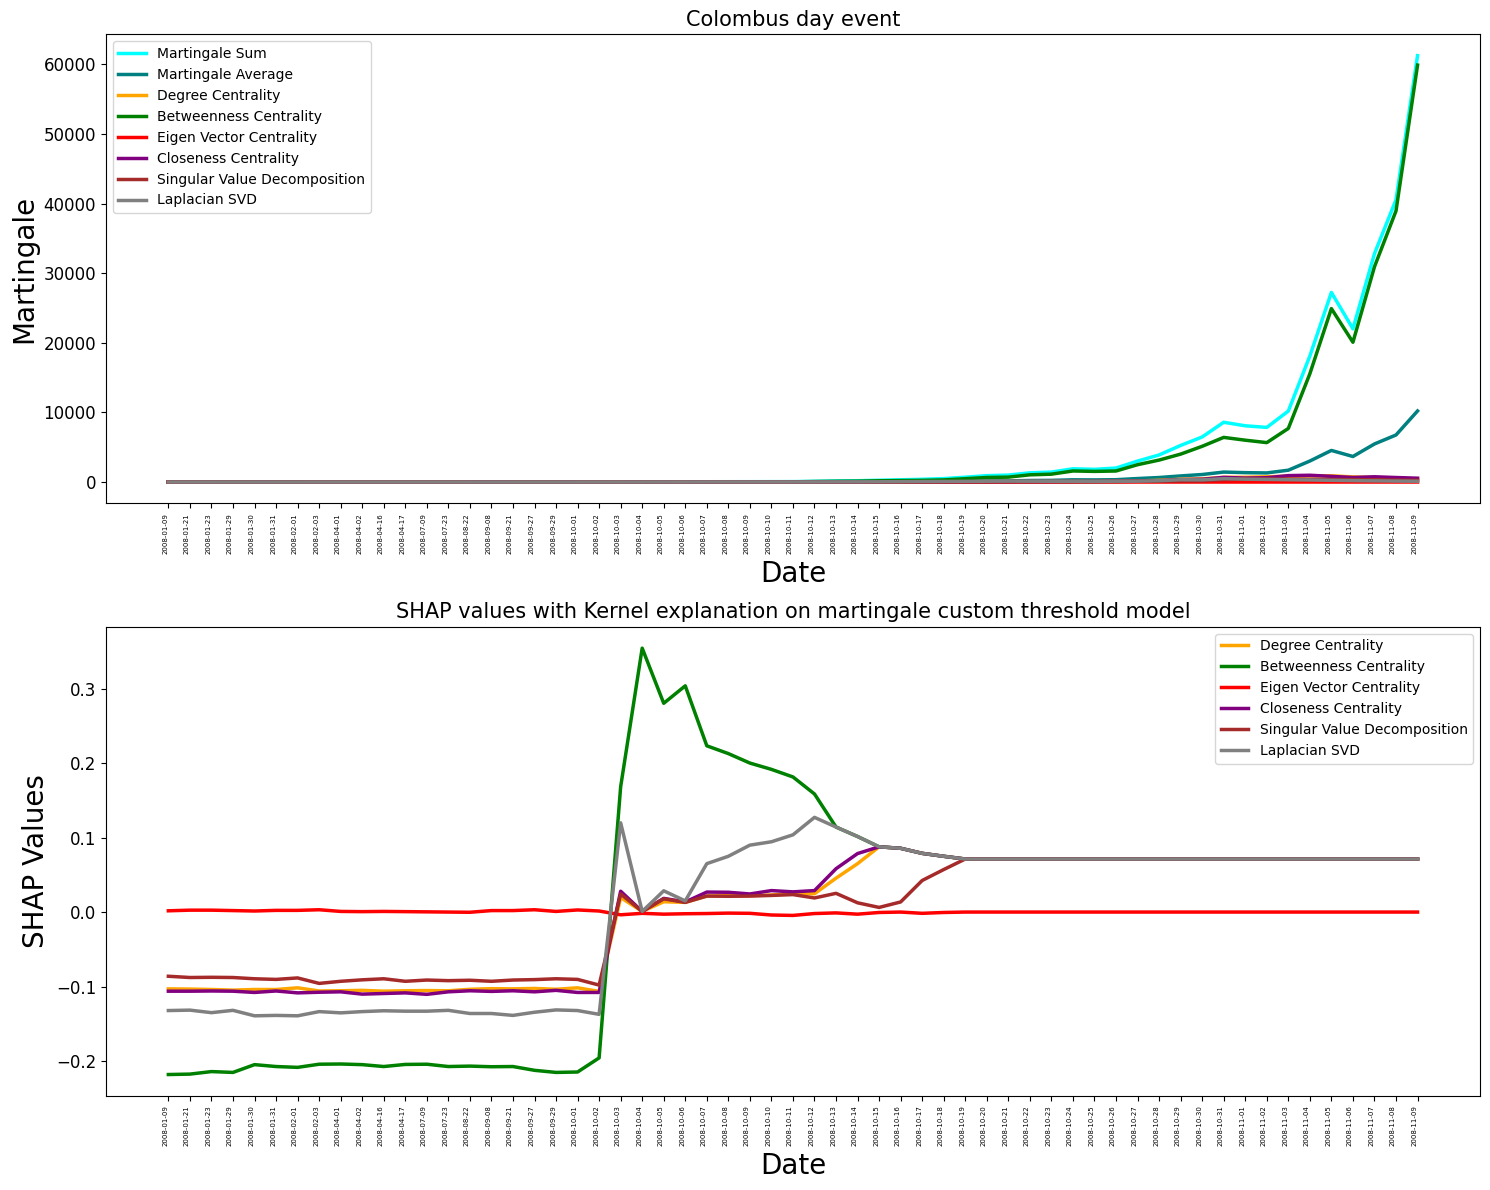

In [45]:
dates_ColumbusDay = filtered_dates.astype(str)[1:60]
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('Martingale', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Colombus day event', fontsize = 15)

ax = sns.lineplot(y = Msum_cd, x= dates_ColumbusDay, color = 'cyan', label='Martingale Sum', linewidth = 2.5)
sns.lineplot(y = Mavg_cd, x = dates_ColumbusDay, color = 'teal', label='Martingale Average', linewidth = 2.5)
sns.lineplot(y = Mdc_cd['martingales'], x = dates_ColumbusDay, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = Mbc_cd['martingales'], x = dates_ColumbusDay, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = Mev_cd['martingales'], x = dates_ColumbusDay, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = Mcc_cd['martingales'], x = dates_ColumbusDay, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = Msvd_cd['martingales'], x = dates_ColumbusDay, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = Mlsvd_cd['martingales'], x = dates_ColumbusDay, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)


plt.subplot(2,1,2)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('SHAP Values', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('SHAP values with Kernel explanation on martingale custom threshold model', fontsize = 15)


ax = sns.lineplot(y = shap_values3[:,0], x = dates_ColumbusDay, color = 'orange', label='Degree Centrality', linewidth = 2.5)

sns.lineplot(y = shap_values3[:,1], x = dates_ColumbusDay, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,2], x = dates_ColumbusDay, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,3], x = dates_ColumbusDay, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,4], x = dates_ColumbusDay, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,5], x = dates_ColumbusDay, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)

# plt.title('Martingales for MIT dataset', fontsize = 20)

plt.tight_layout()
plt.show()

# The following code will be performed on Martingale average

# Evaluation Metrics

In [6]:
def runTest(obj, threshold, adjacency_matrices, vectors, title, trials):
  df_dict = {}
  for i in range(1, trials+1):
    obj.martingaleTest(vectors, threshold)
    # Pvalues = obj.pvalues
    # strangeness = obj.saved_strangeness
    martingales = obj.saved_martingales
    anomaly_instants = obj.change_detected_instant
    anomalous_martingales = list(filter(lambda x : x > th, martingales))
    total_summary_df = pd.DataFrame({'Martingales' : martingales[1:], 'Is Anomaly': [True if x in anomaly_instants else False for x in range(len(adjacency_matrices)) ]})

    df_dict[i] = total_summary_df


  return df_dict

def runMultiTest(obj, threshold, adjacency_matrices, f_matrix, title, trials):
  df_dict = {}
  for i in range(1, trials+1):
    obj.multiviewMartingaleTest(f_matrix, threshold)
    # Pvalues = obj.pvalues
    # strangeness = obj.saved_strangeness
    martingales = obj.saved_martingale_sum
    anomaly_instants = obj.change_detected_instant
    anomalous_martingales = list(filter(lambda x : x > th, martingales))
    total_summary_df = pd.DataFrame({'Martingales' : martingales[1:], 'Is Anomaly': [True if x in anomaly_instants else False for x in range(len(adjacency_matrices)) ]})

    df_dict[i] = total_summary_df


  return df_dict

def true_false_positives(df_dict, GROUNDTRUTH):
  TP = []
  FP = []
  Delay_time = []

  anomaly_indices = df_dict[df_dict['Is Anomaly'] == True ].index
  for i in anomaly_indices:
    if i > GROUNDTRUTH and len(TP)==0:
      TP.append(i)
      TRUE_POSITIVES.append(i)
      if len(TP)>0:
        Delay_time.append(i-GROUNDTRUTH)
        ALL_DELAYS.append(i-GROUNDTRUTH)
    else:
      FP.append(i)
      FALSE_POSITIVES.append(i)
  print('----------------------------------------------')
  print('True Positives: ', TP)
  print('False Positives: ', FP)
  print('Delay Time: ', Delay_time)

def true_false_negatives(df_dict):
  FN = []
  TN = []
  anomaly_indices = df_dict[df_dict['Is Anomaly'] == True].index
  for i in anomaly_indices:
    FN.append(i)
    FALSE_NEGATIVES.append(i)
  non_anomaly_indices = df_dict[df_dict['Is Anomaly'] == False].index
  for i in non_anomaly_indices:
    TN.append(i)
    TRUE_NEGATIVES.append(i)
  print('----------------------------------------------')
  print('FALSE NEGATIVES', FN)

def Precision(data_dict, title):
  for i in data_dict:
    true_false_positives(data_dict[i], GROUNDTRUTH)

def Positive_rates(data_dict):
  for i in data_dict:
    true_false_negatives(data_dict[i])


In [7]:
my_graphs = GraphGenerators()

graphs_type_1 = my_graphs.barabasiAlbert(n= 30,m1 = 3, m2 = 7, set1= 100, set2 = 100)
my_graphs = GraphGenerators()
graphs_type_1n = my_graphs.barabasiAlbert(n= 30,m1 = 5, m2 = 5, set1= 100, set2 = 100)

# graphs_type_2 = my_graphs.newmanWatts(n= 50, p1= 0.4, p2= 0.7, k1=3, k2=5, set1=100, set2=100)
# my_graphs = GraphGenerators()
# graphs_type_2n = my_graphs.newmanWatts(n= 50, p1= 0.5, p2= 0.5, k1=3, k2=5, set1=100, set2=100)

# graphs_type_3 = my_graphs.erdosRenyi(n= 30, p1 = 0.4, p2 = 0.8, set1= 100, set2 = 100)
# my_graphs = GraphGenerators()
# graphs_type_3n = my_graphs.erdosRenyi(n= 30, p1 = 0.5, p2 = 0.5, set1= 100, set2 = 100)


In [ ]:
TRIALS = 20
GROUNDTRUTH = 101


meanPrecision = []
meanF1score = []
meanTPR = []
meanFPR = []
meanMissdetection = []
meanDelaytime = []

thresholds = [5, 10, 15, 20]

Obj_p = ChangePointDetection(graphs_type_1)
# dc_p = Obj_p.deg_centrality(graphs_type_1)
# bc_p = Obj_p.betweenness_centrality(graphs_type_1)
# ev_p = Obj_p.eigenvector_centrality(graphs_type_1)
# cc_p = Obj_p.closeness_centrality(graphs_type_1)
# svd_p = Obj_p.SVDEmbedding(graphs_type_1)
lsvd_p = Obj_p.LSVDembedding(graphs_type_1)
# f_matrix_p = [svd_p, lsvd_p, ev_p]

Obj_n = ChangePointDetection(graphs_type_1n)
# dc_n = Obj_n.deg_centrality(graphs_type_1n)
# bc_n = Obj_n.betweenness_centrality(graphs_type_1n)
# ev_n = Obj_n.eigenvector_centrality(graphs_type_1n)
# cc_n = Obj_n.closeness_centrality(graphs_type_1n)
# svd_n = Obj_n.SVDEmbedding(graphs_type_1n)
lsvd_n = Obj_n.LSVDembedding(graphs_type_1n)
# f_matrix_n = [svd_n, lsvd_n, ev_n]

for th in thresholds:
  MISS_DETECTION = []
  TRUE_POSITIVES = []
  FALSE_POSITIVES = []
  TRUE_NEGATIVES = []
  FALSE_NEGATIVES = []
  ALL_DELAYS = []

  # FOR SINGLE FEATURE MARTINGALE TEST
  df_dict_cent_p = runTest(obj=Obj_p, threshold= th, adjacency_matrices= graphs_type_1, vectors=lsvd_p, title='LSVD', trials=TRIALS)
  df_dict_cent_n = runTest(obj=Obj_n, threshold=th, adjacency_matrices=graphs_type_1n, vectors=lsvd_n, title='LSVD', trials=TRIALS)

  # # FOR MULTI TEST
  # df_dict_cent_p = runMultiTest(Obj_p, th, graphs_type_1, f_matrix_p, 'Combined Martingale', TRIALS)
  # df_dict_cent_n = runMultiTest(Obj_n, th, graphs_type_1n, f_matrix_n, 'Combined Martingale', TRIALS)
  Precision(df_dict_cent_p, 'LSVD')

  #Precision
  try:
    PRECISION_CENT = len(TRUE_POSITIVES)/(len(TRUE_POSITIVES) + len(FALSE_POSITIVES))
  except ZeroDivisionError:
    PRECISION_CENT = 0

  Positive_rates(df_dict_cent_n)

  #Recall
  try:
    TRUE_POSITIVE_RATE = len(TRUE_POSITIVES)/(len(TRUE_POSITIVES)+ len(FALSE_NEGATIVES))
  except ZeroDivisionError:
    TRUE_POSITIVE_RATE = 0

  #FPR
  try:
    FALSE_POSITIVE_RATE = len(FALSE_POSITIVES)/ (len(FALSE_POSITIVES)+ len(TRUE_NEGATIVES))
  except ZeroDivisionError:
    FALSE_POSITIVE_RATE = 0

  #F1 score
  try:
    F1_SCORE = ((2*PRECISION_CENT*TRUE_POSITIVE_RATE)/(PRECISION_CENT + TRUE_POSITIVE_RATE))
  except ZeroDivisionError:
    F1_SCORE = 0
  #Miss Detection
  MISS_DETECTION.append(TRIALS - len(TRUE_POSITIVES))
  meanPrecision.append((PRECISION_CENT))
  meanFPR.append((FALSE_POSITIVE_RATE))
  meanTPR.append((TRUE_POSITIVE_RATE))
  meanF1score.append((F1_SCORE))
  meanMissdetection.append((MISS_DETECTION))
  meanDelaytime.append(np.mean(ALL_DELAYS))

model_summary_mean = pd.DataFrame({'Precision': meanPrecision, 'FPR': meanFPR, 'TPR': meanTPR, 'F1 score': meanF1score, 'missdetection' : meanMissdetection, 'meanDelay': meanDelaytime, 'Threshold': thresholds})

model_summary_mean

## The result for the above code with Laplacian SVD feature of Barabasi Albert Evolving Graph using ∆p = 4 and varying threshold

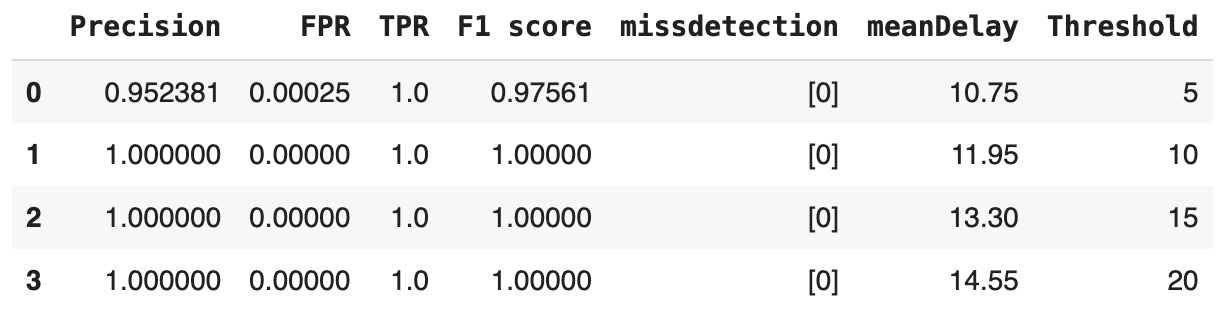

# Plot the graph using the above values by varying desired Graph generating model, Type of graph feature, ∆p, threshold, number of trials.